# DeepWeeds - MobileNet

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import shutil

seed = 999
def seedEverything(seed, deterministic = False):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

    if deterministic:
        tf.config.experimental.enable_op_determinism()

        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        tf.config.threading.set_inter_op_parallelism_threads(2)
        tf.config.threading.set_intra_op_parallelism_threads(2)


seedEverything(seed, True)

2025-05-05 05:45:32.071126: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-05 05:45:32.071279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-05 05:45:32.202834: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [3]:
# data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info = pd.read_csv("/kaggle/input/deepweeds/labels.csv") ## For Kaggle
data_info

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple
...,...,...,...
17504,20180322-133822-1.jpg,8,Negative
17505,20180322-133832-1.jpg,8,Negative
17506,20180322-133840-1.jpg,8,Negative
17507,20180322-133850-1.jpg,8,Negative


In [4]:
data_info[['Species','Label']].groupby(by='Species').count().T

Species,Chinee apple,Lantana,Negative,Parkinsonia,Parthenium,Prickly acacia,Rubber vine,Siam weed,Snake weed
Label,1125,1064,9106,1031,1022,1062,1009,1074,1016


In [5]:
label2id = data_info[['Species','Label']].groupby(by='Species').min().to_dict()['Label']
id2label = {label2id[i]:i for i in label2id}
id2label

{0: 'Chinee apple',
 1: 'Lantana',
 8: 'Negative',
 2: 'Parkinsonia',
 3: 'Parthenium',
 4: 'Prickly acacia',
 5: 'Rubber vine',
 6: 'Siam weed',
 7: 'Snake weed'}

In [6]:
low_data_labels = data_info[data_info['Species'] != "Negative"]['Label'].unique() ## labels with very low data
low_data_labels

array([0, 1, 7, 6, 4, 3, 5, 2])

# Splitting Data into Train:Valid:Test Splits (60:20:20)

In [7]:
# colabAI prompt: train test split using data_info
from sklearn.model_selection import train_test_split, StratifiedKFold

### K-Fold Validation-----
#####---------------------
split_index = 0 # index to retrieve
print("Using KFold: Index",split_index+1,"out of 5 folds")
print("-------------------------------------------------\n")

# skfold = StratifiedKFold()
# kSplits = skfold.split(data_info['Filename'], y=data_info['Label'])

# for index in range(skfold.get_n_splits()):
#     train_index, test_index = next(kSplits)
#     if index == split_index:
#         break

# trax, tex, tray, tey = train_test_split(data_info['Filename'],data_info['Label'], test_size=0.4, random_state=seed)
# train_data = pd.DataFrame({"Filename":trax,"label":tray})

# trax, tex, tray, tey = train_test_split(tex,tey, test_size=0.5, random_state=seed)
# valid_data = pd.DataFrame({"Filename":trax,"label":tray})
# test_data = pd.DataFrame({"Filename":tex,"label":tey})

Using KFold: Index 1 out of 5 folds
-------------------------------------------------



In [8]:
train_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/train_subset{}.csv'.format(split_index)) ## for GoogleColab
train_data.rename(columns={"Label":"label"}, inplace=True)

valid_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/val_subset{}.csv'.format(split_index)) ## for GoogleColab
valid_data.rename(columns={"Label":"label"}, inplace=True)
test_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/test_subset{}.csv'.format(split_index)) ## for GoogleColab
test_data.rename(columns={"Label":"label"}, inplace=True)

print("Is There Duplicates: ", not valid_data[valid_data['Filename'].isin(test_data['Filename'])].empty)
print("Train Data\n--------\n",train_data.groupby(by='label').count().T, "\tTotal:", train_data.shape)
print("Validation Data\n--------\n",valid_data.groupby(by='label').count().T, "\tTotal:", valid_data.shape)
print("Test Data\n--------\n",test_data.groupby(by='label').count().T, "\tTotal:", test_data.shape)

Is There Duplicates:  False
Train Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  675  637  618  613  637  605  644  609  5463 	Total: (10501, 2)
Validation Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  213  206  204  212  202  215  203  1821 	Total: (3501, 2)
Test Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  226  213  207  205  213  202  215  204  1822 	Total: (3507, 2)


# Helper Functions

- Organize Images to Directory as per Label for Creating Generator (organize_data_to_directory)
- Dataset Generator (getDatasetGenerators) - works in tandem with "organize_data_to_directory"
- Class Weights For Imbalanced Dataset (getWeightedClass)
- Accuracy / Loss plot (plot_loss_acc)
- Evaluation Metrics Calculation (eval_model, print_stats, calcFalseRate)
- Prediction with Threshold as used by DeepWeeds Author (prediction_argmax)



In [9]:
from tqdm import tqdm

def organize_data_to_directory(data_info,source_dir='',target_dir='',oversample=0,oversampling_labels=[]):
    for index, row in tqdm(data_info.iterrows()):
        filename = row['Filename']
        label = row['label']

        source = os.path.join(source_dir,filename)

        #if not os.path.exists(source):
        #    print("File Doesn't Exist", source)
        #    continue

        target_path = os.path.join(target_dir,str(label))
        target = os.path.join(target_path,filename)
        # print(source,target)

        if not os.path.exists(target_path):
            os.mkdir(target_path)

        if not os.path.exists(target):
            if oversample and (label in oversampling_labels):
                for i in range(oversample):
                    sample_filename = os.path.join(target_path, "oversample-"+str(i)+"-"+filename)
                    shutil.copy(source, sample_filename)

            shutil.copy(source,target)

##-----------------------------
###----------------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

def getDatasetGenerators(train_dir, **kwargs):
    # --------------------
    # Flow training images in batches using generator
    # --------------------
    generator = image_dataset_from_directory(
        train_dir,
        **kwargs
    )

    return generator

In [10]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def prediction_argmax(prediction, rand_guess=1):
    prediction = np.asarray(prediction)
    l_pred = np.argmax(prediction[low_data_labels])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def calcFalsePositiveRate(a_label, p_label, label_names=None, n_class=None):
    if n_class is None:
        n_class = len(np.unique(a_label))
    conf_mat = tf.math.confusion_matrix(a_label, p_label, num_classes=n_class).numpy()

    false_rate = []
    total = len(a_label)
    for i in range(n_class):
        tP = conf_mat[i][i]
        fN = np.sum(conf_mat[i,:]) - tP

        fP = np.sum(conf_mat[:,i]) - tP
        tN = total - (tP + fN + fP)

        fP_Rate = fP/(tN+fP)
        # fN_Rate = fN/(tP+fN)
        accuracy = tP / (tP+fN)

        false_rate.append((fP_Rate,accuracy))

    false_rate = pd.DataFrame(false_rate, columns=["False Positive Rate", "Accuracy"], index=label_names)
    return false_rate

def printStats(actual_labels,prediction, use_rand_guess= 0):
    if use_rand_guess:
        prediction = [prediction_argmax(x, rand_guess=use_rand_guess) for x in prediction]
    else:
        prediction = [np.argmax(x) for x in prediction]

    print("Evaluation Metrics\n=================================\n")
    #     print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    #     print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    #     print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    #     print("accuracy_Score",accuracy_score(actual_labels,prediction))

    label_names = [id2label[i] for i in range(len(id2label))]
    print(classification_report(actual_labels, prediction,digits=5, target_names=label_names))
    print()
    print(calcFalsePositiveRate(actual_labels, prediction, label_names = label_names))
    print()
    print("Confusion Matrix\n=================================\n")
    n_class = np.unique(actual_labels).shape[0]
    cmd = ConfusionMatrixDisplay.from_predictions(
        actual_labels, prediction,
        display_labels=label_names,
        xticks_rotation=45 #'vertical'
    )
    #cmd.plot()
    plt.show()

def eval_model(model, data_gen, use_rand_guess=False):
    print("model.evaluate")
    model.evaluate(data_gen)

    print("model.predict")
    actual_labels = []
    pred_prob = []
    for batch in tqdm(data_gen):
        actual_labels.extend([np.argmax(z) for z in batch[1]])
        pred_prob.extend(list(model(batch[0], training=False)))

    printStats(actual_labels,pred_prob,use_rand_guess)
    return actual_labels, pred_prob


def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    if 'peaks' in history:
        peaks = history['peaks']
    else:
        _min = np.argmin(val_loss)
        peaks = [_min]

    epochs = range(len(acc))
    print("Total Epochs:",epochs)

    plt.figure(figsize=[16, 4])
    plt.subplot(1,2,1)
    p_value = [val_acc[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, acc, label='Training accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='magenta')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    p_value = [val_loss[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='magenta')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Creating Dateset ImageGenerator

In [11]:
IMG_SIZE=(224,224,3)
oversampling = 0 # How many times are we gonna over sample

if oversampling:
    print("Oversampling",oversampling,"times for labels",low_data_labels)
else:
    print("No OverSampling")

# base_dir = '/content/dataset_9c' ## For GoogleColab
# input_dir = '/content/images' ## For GoogleColab

input_dir = "/kaggle/input/deepweeds/images" ## For Kaggle
base_dir = "/kaggle/working/deepweeds_9c" ## For Kaggle

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

## Organizing Training Data
organize_data_to_directory(train_data, source_dir=input_dir, target_dir=train_dir, oversample=oversampling, oversampling_labels=low_data_labels)

# ## Organizing Validation Data
organize_data_to_directory(valid_data, source_dir=input_dir, target_dir=validation_dir)

# ## Organizing Test Data
organize_data_to_directory(test_data, source_dir=input_dir, target_dir=test_dir)

No OverSampling


10501it [00:46, 225.85it/s]
3501it [00:14, 248.02it/s]
3507it [00:15, 230.77it/s]


In [12]:
train_generator = getDatasetGenerators(
      train_dir,
      batch_size=32,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

validation_generator = getDatasetGenerators(
      validation_dir,
      batch_size=16,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

test_generator = getDatasetGenerators(
      test_dir,
      batch_size=16,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=False
)

Found 10501 files belonging to 9 classes.
Found 3501 files belonging to 9 classes.
Found 3507 files belonging to 9 classes.


# Sample Images

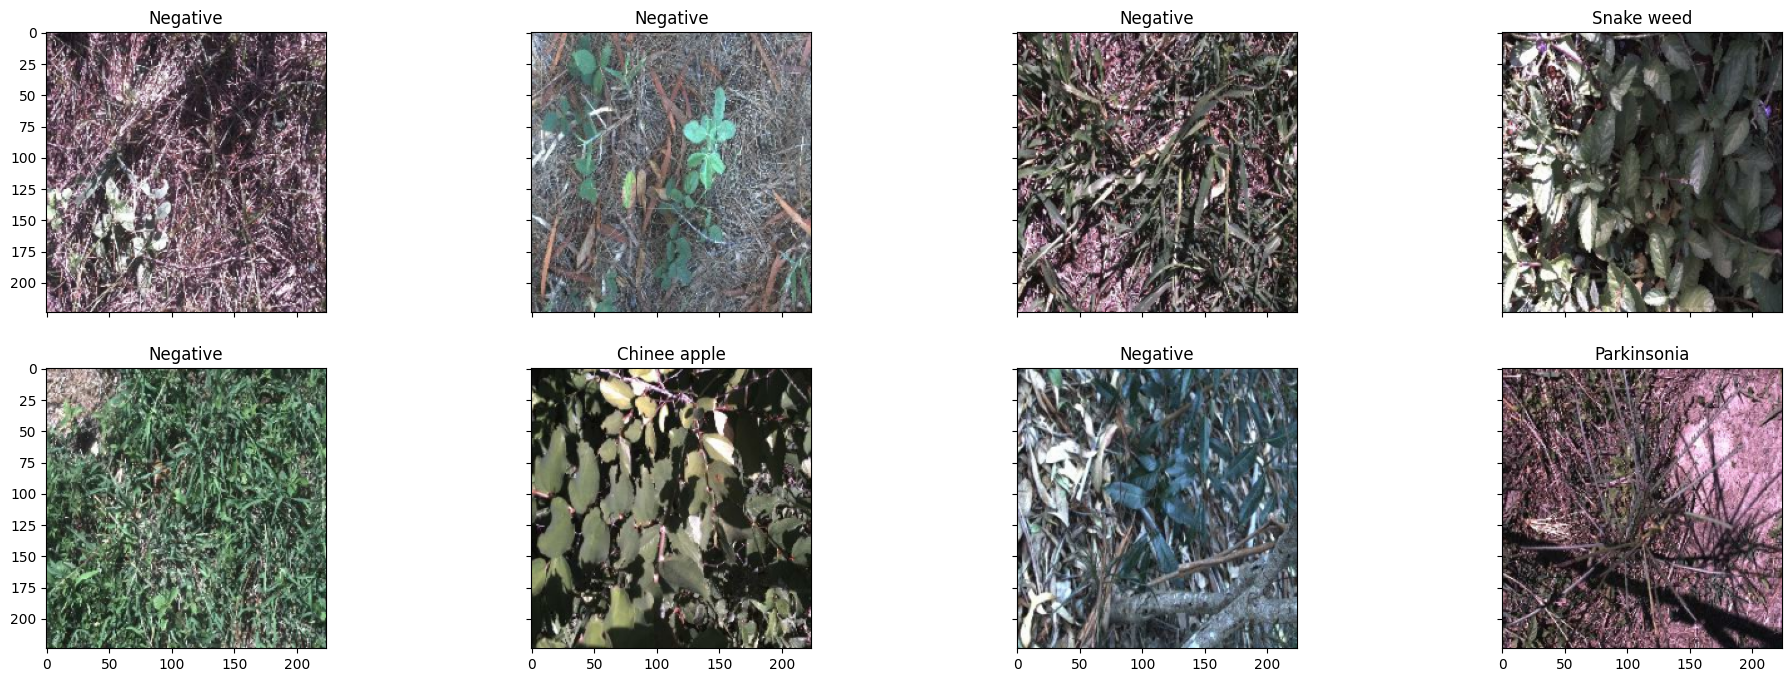

In [13]:
#image visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))

for images, labels in validation_generator:
    for i in range(2):
        for j in range(4):
            ax[i][j].imshow(images[i+j*2].numpy().astype(np.int32))
            ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

    break
plt.show()

In [14]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPool2D, Reshape, \
                        Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, Average
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid, softmax

class ChannelWiseMaxPool(tf.keras.layers.Layer):
    def __init__(self,pool_size=2,stride=None,padding='valid',data_format='channels_last', **kwargs):
        super(ChannelWiseMaxPool,self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.padding = padding
        if stride is None:
            self.stride = self.pool_size

        self.data_format = 'channels_last' if data_format == 'channels_first' else 'channels_first'
        self.max = tf.keras.layers.MaxPool1D(self.pool_size, self.stride, padding=self.padding, data_format=self.data_format)

    def build(self,input_shape):
        self.reshape_forward = tf.keras.layers.Reshape((-1,input_shape[-1]))
        self.reshape_backward= tf.keras.layers.Reshape((input_shape[1], input_shape[2], -1))

    def call(self,x):
        x = self.reshape_forward(x)
        x = self.max(x)
        x = self.reshape_backward(x)
        return x

class ChannelWiseAvgPool(tf.keras.layers.Layer):
    def __init__(self,pool_size=2,stride=None,padding='valid',data_format='channels_last', **kwargs):
        super(ChannelWiseAvgPool,self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.padding = padding
        if stride is None:
            self.stride = self.pool_size

        self.data_format = 'channels_last' if data_format == 'channels_first' else 'channels_first'
        self.avg = tf.keras.layers.AveragePooling1D(self.pool_size, self.stride, padding=self.padding, data_format=self.data_format)

    def build(self,input_shape):
        self.reshape_forward = tf.keras.layers.Reshape((-1,input_shape[-1]))
        self.reshape_backward= tf.keras.layers.Reshape((input_shape[1], input_shape[2], -1))

    def call(self,x):
        x = self.reshape_forward(x)
        x = self.avg(x)
        x = self.reshape_backward(x)
        return x

def GlobalAverageOfMaximums(x, max_pool_size=2, layer_num=1, keep_out_dims=False):
    _max = layers.MaxPooling2D(pool_size=max_pool_size,padding='same', name="Maximums_L{}".format(layer_num))(x)
    _avg = layers.GlobalAveragePooling2D(name="Average_of_Maximums_L{}".format(layer_num), keepdims=keep_out_dims)(_max)
    return _avg

In [15]:
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPool2D, Reshape, \
Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, Average
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid, softmax

def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """

    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8, seed=42):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer=keras.initializers.HeUniform(seed),
                             use_bias=True,
                             bias_initializer=keras.initializers.GlorotUniform(seed),
                           name='Dense_Squeeze_CA')
    shared_layer_two = Dense(channel,
                             kernel_initializer=keras.initializers.HeUniform(seed),
                             use_bias=True,
                             bias_initializer=keras.initializers.GlorotUniform(seed),
                           name='Dense_Excite_CA')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)

    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel//ratio)

    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)

    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1,1,channel//ratio)

    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)

    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])



def spatial_attention(input_feature, seed=42):
    kernel_size = 5

    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1

    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1

    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2

    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer=keras.initializers.HeUniform(seed),
                    use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

In [16]:
import math
### MFSA
def MultiFilterSpatialAttention(input_feature, kernel_size=7, num_pooled_channel=4, seed=42, layer_num = 0):
    in_shape = input_feature.shape

    stride = int(math.ceil(in_shape[-1] / num_pooled_channel))
    pool_size = (stride * 2)

    channel_avg = ChannelWiseAvgPool(pool_size, stride, padding='same', name='MFSA_SAP_L{}'.format(layer_num))(input_feature)
    channel_max = ChannelWiseMaxPool(pool_size, stride, padding='same' , name='MFSA_SMP_L{}'.format(layer_num))(input_feature)

    concat = layers.Concatenate(axis=3, name='MFSA_ConcatChannels_L{}'.format(layer_num))([channel_avg, channel_max])

    mfsa_out = layers.Conv2D(filters = in_shape[-1],
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer=keras.initializers.HeUniform(seed),
                    use_bias=False,
                    groups=num_pooled_channel,
                    name="MFSA_Conv_L{}".format(layer_num))(concat)	
    
    mfsa_out =  layers.Multiply(name="MFSA_Multiply_L{}".format(layer_num))([input_feature, mfsa_out])
    
    return mfsa_out

# Building MobileNet Model

In [ ]:
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.applications import EfficientNetV2S, ConvNeXtSmall

def augment(seed=42):
    return keras.Sequential([
        layers.RandomBrightness(0.3, (0, 1),seed=seed, name='RR_Bright'),
        # layers.RandomContrast(0.3, seed=seed, name='RR_Contr'), # can't run deterministically
        layers.RandomFlip(seed=seed, name='RR_Flip'),
        layers.RandomRotation(0.5, seed=seed, name='RR_Rot'),
        layers.RandomTranslation(0.4, 0.4, seed=seed, name='RR_Trans'),
        layers.RandomZoom(0.2, 0.2, seed=seed, name='RR_Zoom'),
        layers.GaussianDropout(0.01, seed=seed, name='RR_Gauss'),
    ], name='augment_pipeline')


def skipAugment(model):
    inputs = keras.Input(shape=IMG_SIZE)
    x = inputs
    for layer in model.layers:
        if 'augment' not in layer.name and 'input' not in layer.name:
            x = layer(x)

    model = keras.Model(inputs=inputs, outputs=x, name=model.name)
    return model

def hard_swish(x):
    relu6 = layers.ReLU(max_value=6)
    return x * (relu6(x + 3) / 6)

def MobilenetV3Base(img_size, use='S'): # use = S (small) or L (large)
    # Load the MobileNet model with weights pre-trained on ImageNet.
    if(use=='S'):
        mobilenet = MobileNetV3Small(input_shape=img_size, weights='imagenet', include_preprocessing=False)
    if(use=='L'):
        mobilenet = MobileNetV3Large(input_shape=img_size, weights='imagenet', include_preprocessing=False)
        
    mobilenet.trainable = True

    base_index = 0
    for i in range(len(mobilenet.layers)):
        if('global_average_pooling2d' in mobilenet.layers[i].name):
            base_index = i
            break
            
    out_layer = mobilenet.layers[base_index-1]
    base_model =  keras.Model(inputs=mobilenet.layers[0].output, outputs=out_layer.output, name = mobilenet.name+"_base_")
    base_model.trainable = True
    
    pi0 = base_index+1 # pooler index start
    pi1 = base_index+1 # pooler index end
    for i in range(base_index, len(mobilenet.layers)):
        if('dropout' in mobilenet.layers[i].name):
            pi1 = i
            break
    
    pooler = keras.Model(inputs=mobilenet.layers[pi0].input, outputs=mobilenet.layers[pi1].output, name="MobileNet-Pooler")
    
    return base_model , pooler

def buildModel(IMG_SIZE, mtype = 'S'):
    # Load the MobileNet model with weights pre-trained on ImageNet.
    base_model, pooler = MobilenetV3Base(IMG_SIZE, use=mtype)
    base_model.trainable = True
    pooler.trainable = True
    # out_dim = 1024 if "small" in base_model.name.lower() else 1280 if "large" in base_model.name.lower() else base_model.output.shape[-1]

    print("Base Model:", base_model.name)
    print(len(base_model.layers))
    
    # Define the input layer.
    inputs = keras.Input(shape=IMG_SIZE, name='input')

    # Pre-process the input.
    x = layers.Rescaling(1./255, name='PP_Rescale_down')(inputs)
    x = layers.Resizing(IMG_SIZE[0], IMG_SIZE[1], name='PP_Resize')(x)

    x = augment(seed)(x)
    x = base_model(x, training=True)
    x = layers.Dropout(0.2, seed=seed)(x) 
    gavm_x = GlobalAverageOfMaximums(x, keep_out_dims=True)
    
    ### Inverted CBAM
    x = MultiFilterSpatialAttention(x, 5, 16, seed=seed)
    x = channel_attention(x, seed=seed)
    x = layers.Dropout(0.2, seed=seed)(x) 
    ##===================
    ### Global Average of Maximums
    gavm_cbam = GlobalAverageOfMaximums(x, layer_num="Pre-Attention", keep_out_dims=True)

    x = layers.Average()([gavm_x, gavm_cbam])
    x = pooler(x, training=True)    
    flatten = layers.Flatten()
    x = flatten(x)
    
    outputs = layers.Dense(9, kernel_initializer=keras.initializers.HeUniform(seed), activation='softmax')(x)

    model_name = "DeepWeeds-" + base_model.name
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

    return model

In [18]:
model = buildModel(IMG_SIZE)
model.summary()

10734624/10734624 [==============================] - 0s 0us/step
Base Model: MobilenetV3small_base_
228
Model: "DeepWeeds-MobilenetV3small_base_"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 PP_Rescale_down (Rescaling  (None, 224, 224, 3)          0         ['input[0][0]']               
 )                                                                                                
                                                                                                  
 PP_Resize (Resizing)        (None, 224, 224, 3)          0         ['PP_Rescale_down[0][0]']     
                                                              

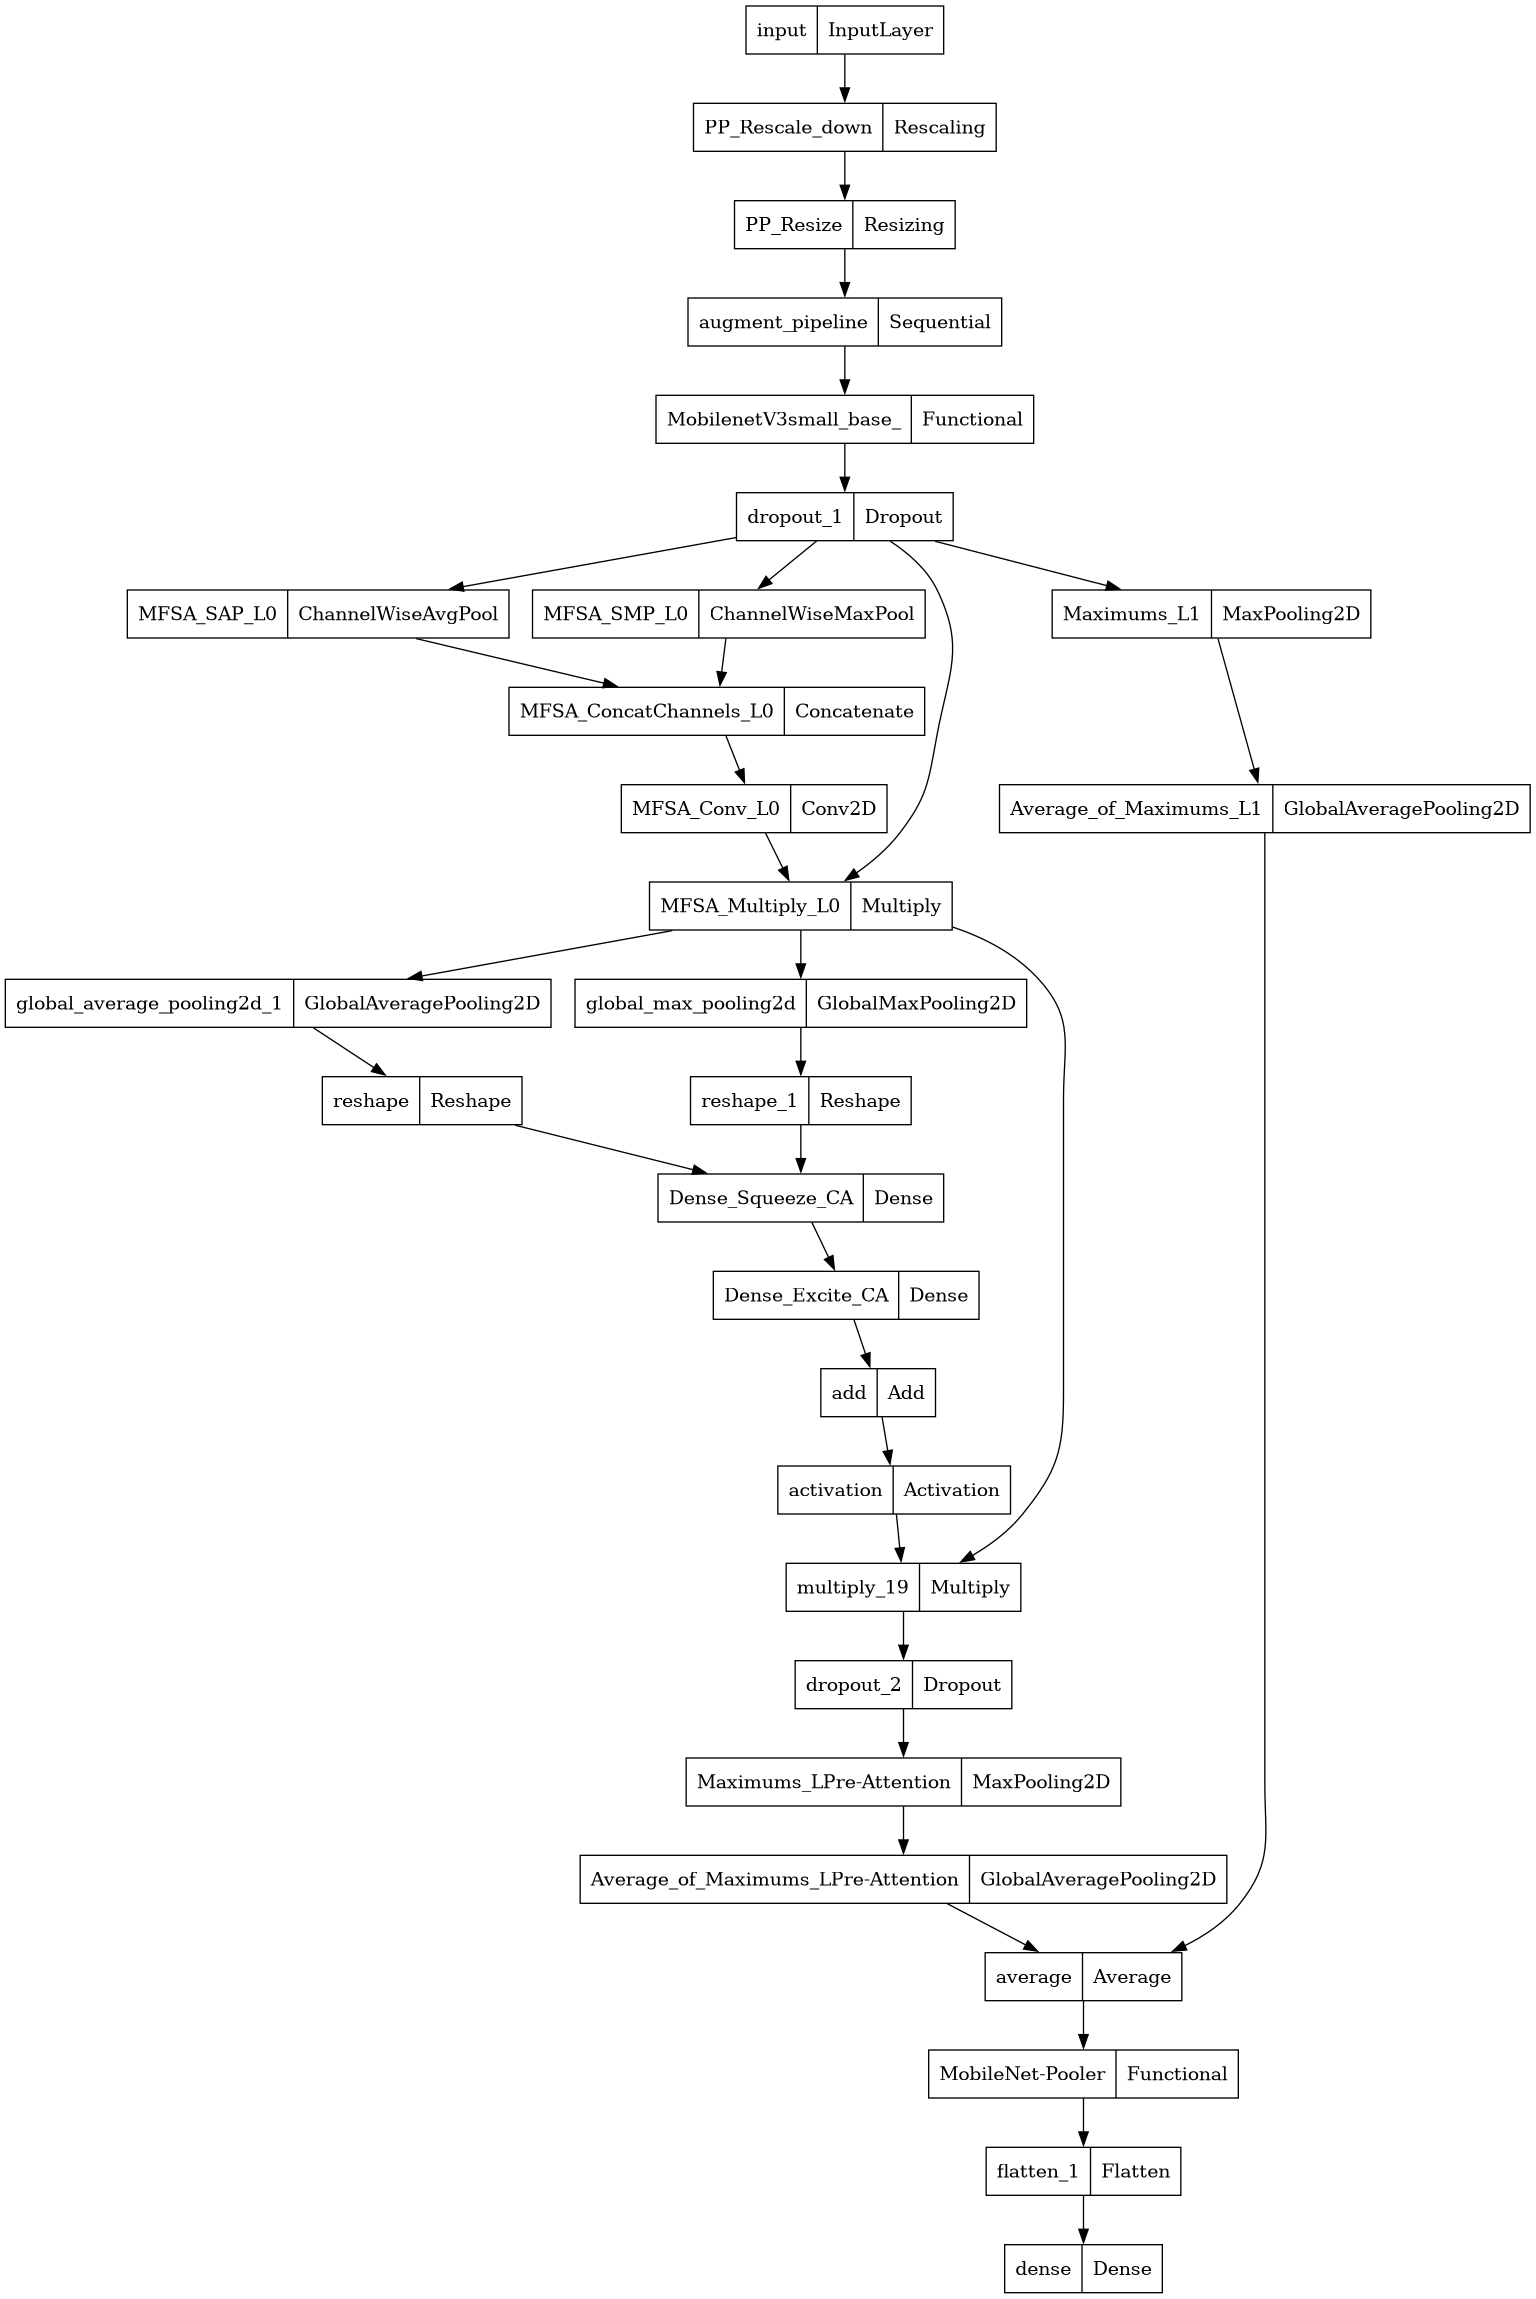

In [19]:
tf.keras.utils.plot_model(model)

# Trial 1 - FineTuning

In [20]:
from tensorflow.keras.optimizers import RMSprop, AdamW

# Constant for epochs
EPOCHS = 200

pat_es = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=pat_es, verbose=1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.8, patience=3, verbose=1, min_lr=1e-6)

model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=2e-4,  weight_decay=5e-2),
          metrics=['accuracy'])

Epoch 1/200


2025-05-05 05:47:21.710493: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-MobilenetV3small_base_/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1746424046.528108      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


329/329 [==============================] - 56s 83ms/step - loss: 1.2360 - accuracy: 0.5818 - val_loss: 0.8857 - val_accuracy: 0.6918 - lr: 2.0000e-04
Epoch 2/200
329/329 [==============================] - 26s 77ms/step - loss: 0.8465 - accuracy: 0.7013 - val_loss: 0.7098 - val_accuracy: 0.7481 - lr: 2.0000e-04
Epoch 3/200
329/329 [==============================] - 26s 78ms/step - loss: 0.7065 - accuracy: 0.7487 - val_loss: 0.5790 - val_accuracy: 0.7998 - lr: 2.0000e-04
Epoch 4/200
329/329 [==============================] - 26s 78ms/step - loss: 0.6153 - accuracy: 0.7878 - val_loss: 0.5154 - val_accuracy: 0.8218 - lr: 2.0000e-04
Epoch 5/200
329/329 [==============================] - 26s 78ms/step - loss: 0.5665 - accuracy: 0.8037 - val_loss: 0.4909 - val_accuracy: 0.8378 - lr: 2.0000e-04
Epoch 6/200
329/329 [==============================] - 26s 78ms/step - loss: 0.5197 - accuracy: 0.8174 - val_loss: 0.4570 - val_accuracy: 0.8443 - lr: 2.0000e-04
Epoch 7/200
329/329 [===================

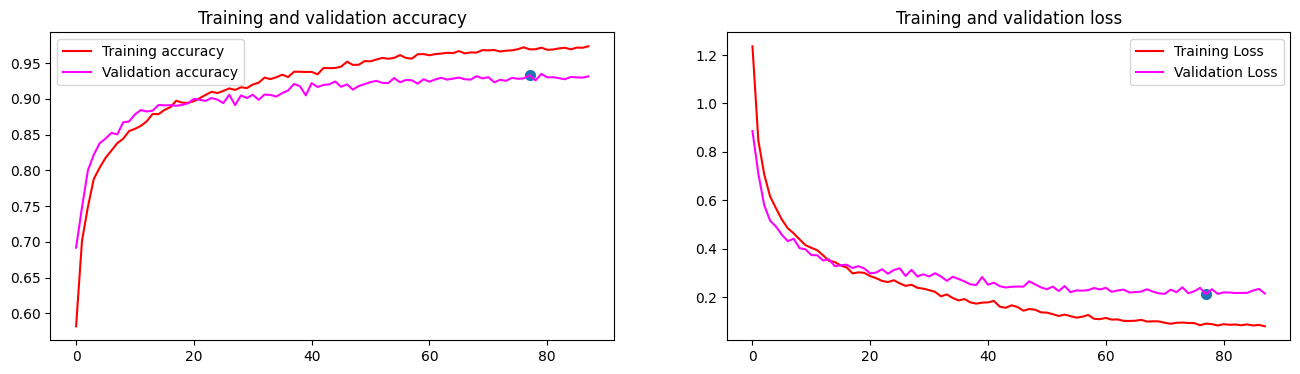

CPU times: user 1h 6min 42s, sys: 3min 28s, total: 1h 10min 10s
Wall time: 38min 30s


In [21]:
%%time

# Train the model
history1 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping, reduce_lr],
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history1.history)

# Evaluation#1

model.evaluate
219/219 [==============================] - 4s 16ms/step - loss: 0.2106 - accuracy: 0.9352
model.predict


100%|██████████| 219/219 [00:36<00:00,  6.07it/s]


Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.87143   0.81333   0.84138       225
       Lantana    0.94258   0.92488   0.93365       213
   Parkinsonia    0.94118   0.93204   0.93659       206
    Parthenium    0.93035   0.91667   0.92346       204
Prickly acacia    0.93103   0.89151   0.91084       212
   Rubber vine    0.91176   0.92079   0.91626       202
     Siam weed    0.95855   0.86047   0.90686       215
    Snake weed    0.86500   0.85222   0.85856       203
      Negative    0.94246   0.97144   0.95673      1821

      accuracy                        0.93145      3501
     macro avg    0.92159   0.89815   0.90937      3501
  weighted avg    0.93116   0.93145   0.93092      3501


                False Positive Rate  Accuracy
Chinee apple               0.008242  0.813333
Lantana                    0.003650  0.924883
Parkinsonia                0.003642  0.932039
Parthenium                 0.004246  0.916667
Prickly acacia    

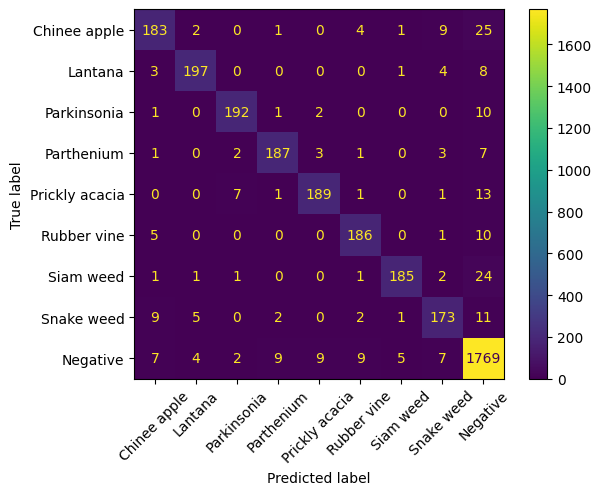

In [22]:
a, b = eval_model(model, validation_generator)

model.evaluate
220/220 [==============================] - 4s 16ms/step - loss: 2.9781 - accuracy: 0.4582
model.predict


100%|██████████| 220/220 [00:35<00:00,  6.14it/s]


Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.14762   0.13717   0.14220       226
       Lantana    0.12821   0.09390   0.10840       213
   Parkinsonia    0.51852   0.06763   0.11966       207
    Parthenium    0.21111   0.09268   0.12881       205
Prickly acacia    0.20513   0.03756   0.06349       213
   Rubber vine    0.16854   0.07426   0.10309       202
     Siam weed    0.18919   0.06512   0.09689       215
    Snake weed    0.15385   0.08824   0.11215       204
      Negative    0.54713   0.81229   0.65385      1822

      accuracy                        0.46165      3507
     macro avg    0.25214   0.16320   0.16984      3507
  weighted avg    0.38721   0.46165   0.39230      3507


                False Positive Rate  Accuracy
Chinee apple               0.054557  0.137168
Lantana                    0.041287  0.093897
Parkinsonia                0.003939  0.067633
Parthenium                 0.021502  0.092683
Prickly acacia    

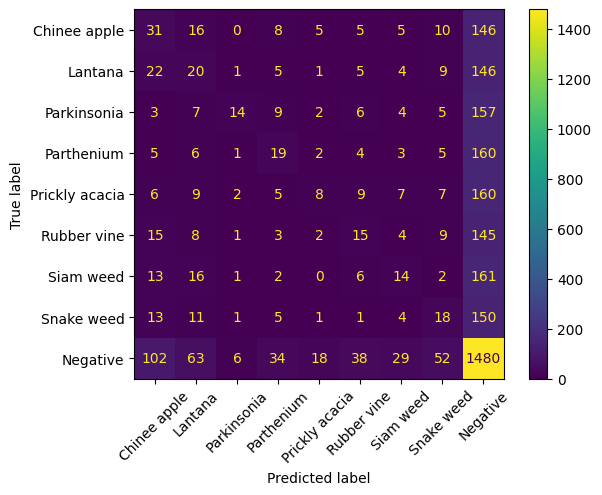

In [23]:
a, b = eval_model(model, test_generator)

# Trial 2 - Freezing Base Model

In [24]:
for layer in model.layers:
    if('mobilenet' in layer.name.lower() or 'pooler' in layer.name.lower()):
        print("Freezing Layer", layer.name)
        layer.trainable = False

model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=2e-5,  weight_decay=5e-5),
          metrics=['accuracy'])

Freezing Layer MobilenetV3small_base_
Freezing Layer MobileNet-Pooler


model.evaluate


2025-05-05 06:27:20.804920: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-MobilenetV3small_base_/MobileNet-Pooler/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


220/220 [==============================] - 5s 14ms/step - loss: 0.1479 - accuracy: 0.9498
model.predict


100%|██████████| 220/220 [00:33<00:00,  6.61it/s]


Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.91071   0.90265   0.90667       226
       Lantana    0.98980   0.91080   0.94866       213
   Parkinsonia    0.94495   0.99517   0.96941       207
    Parthenium    0.93269   0.94634   0.93947       205
Prickly acacia    0.90868   0.93427   0.92130       213
   Rubber vine    0.93467   0.92079   0.92768       202
     Siam weed    0.96190   0.93953   0.95059       215
    Snake weed    0.91327   0.87745   0.89500       204
      Negative    0.96353   0.97146   0.96748      1822

      accuracy                        0.95067      3507
     macro avg    0.94002   0.93316   0.93625      3507
  weighted avg    0.95080   0.95067   0.95054      3507


                False Positive Rate  Accuracy
Chinee apple               0.006096  0.902655
Lantana                    0.000607  0.910798
Parkinsonia                0.003636  0.995169
Parthenium                 0.004240  0.946341
Prickly acacia    

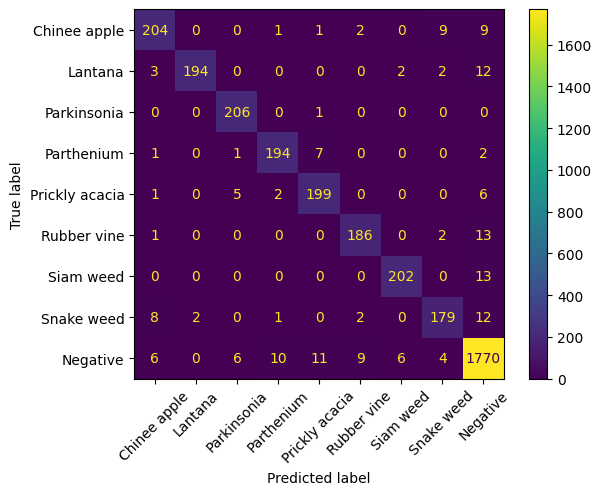

In [25]:
## Test After Freezing
a, b = eval_model(model, test_generator)

Epoch 1/200
329/329 [==============================] - 19s 42ms/step - loss: 0.2214 - accuracy: 0.9212 - val_loss: 0.1530 - val_accuracy: 0.9543 - lr: 2.0000e-05
Epoch 2/200
329/329 [==============================] - 15s 44ms/step - loss: 0.1979 - accuracy: 0.9320 - val_loss: 0.1560 - val_accuracy: 0.9554 - lr: 2.0000e-05
Epoch 3/200
327/329 [============================>.] - ETA: 0s - loss: 0.2022 - accuracy: 0.9281
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.5999999595806004e-05.
329/329 [==============================] - 14s 42ms/step - loss: 0.2026 - accuracy: 0.9281 - val_loss: 0.1588 - val_accuracy: 0.9529 - lr: 2.0000e-05
Epoch 4/200
329/329 [==============================] - 14s 42ms/step - loss: 0.1899 - accuracy: 0.9330 - val_loss: 0.1617 - val_accuracy: 0.9540 - lr: 1.6000e-05
Epoch 5/200
327/329 [============================>.] - ETA: 0s - loss: 0.1797 - accuracy: 0.9350
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.2799999967683107e-05.
329/329 [=======

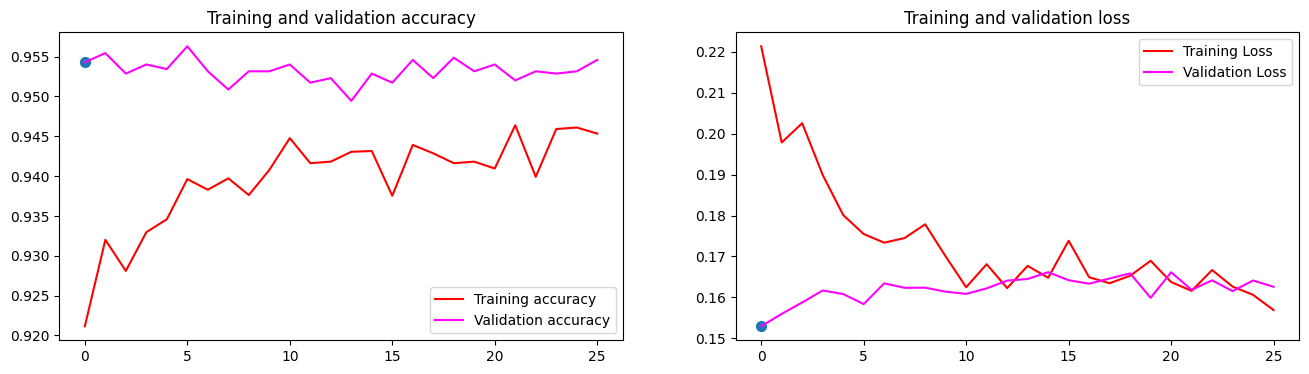

In [26]:
pat_es = 20
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=pat_es, verbose=1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.8, patience=2, verbose=1, min_lr=1e-9)

# Train the model
history2 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping,reduce_lr]
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history2.history)

# Accuracy / Loss Plots

Total Epochs: range(0, 114)


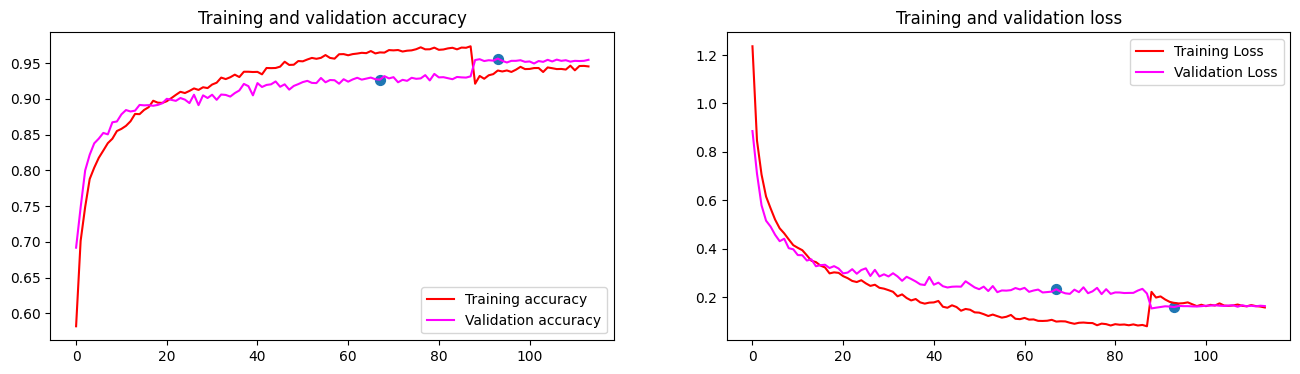

In [27]:
import copy

history = copy.deepcopy(history1.history)

for key in history:
    history[key].extend(history2.history[key])


h1len = len(history1.history['accuracy'])
h2len = len(history2.history['accuracy'])

pat_es +=1
history['peaks'] = [h1len-pat_es, (h1len+h2len)-pat_es]
history['peaks'] = [i if i>=0 else 0 for i in history['peaks']]

plot_loss_acc(history)

Total Epochs: range(0, 88)


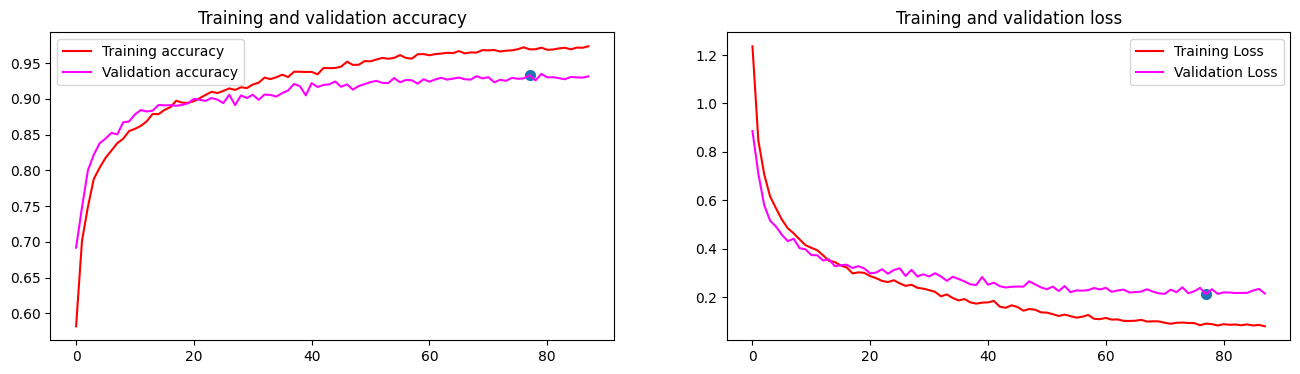

Total Epochs: range(0, 26)


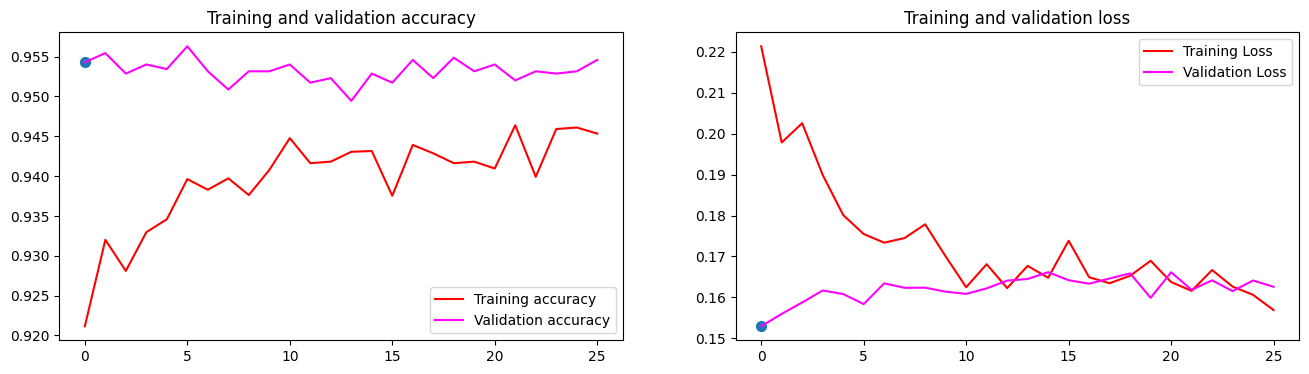

In [28]:
plot_loss_acc(history1.history)
plot_loss_acc(history2.history)

# Evaluation#2

model.evaluate
219/219 [==============================] - 3s 14ms/step - loss: 0.1616 - accuracy: 0.9537
model.predict


100%|██████████| 219/219 [00:32<00:00,  6.82it/s]


Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.91787   0.84444   0.87963       225
       Lantana    0.97059   0.92958   0.94964       213
   Parkinsonia    0.96098   0.95631   0.95864       206
    Parthenium    0.96410   0.92157   0.94236       204
Prickly acacia    0.92202   0.94811   0.93488       212
   Rubber vine    0.94660   0.96535   0.95588       202
     Siam weed    0.91964   0.95814   0.93850       215
    Snake weed    0.90050   0.89163   0.89604       203
      Negative    0.96469   0.97529   0.96996      1821

      accuracy                        0.95173      3501
     macro avg    0.94078   0.93227   0.93617      3501
  weighted avg    0.95167   0.95173   0.95149      3501


                False Positive Rate  Accuracy
Chinee apple               0.005189  0.844444
Lantana                    0.001825  0.929577
Parkinsonia                0.002428  0.956311
Parthenium                 0.002123  0.921569
Prickly acacia    

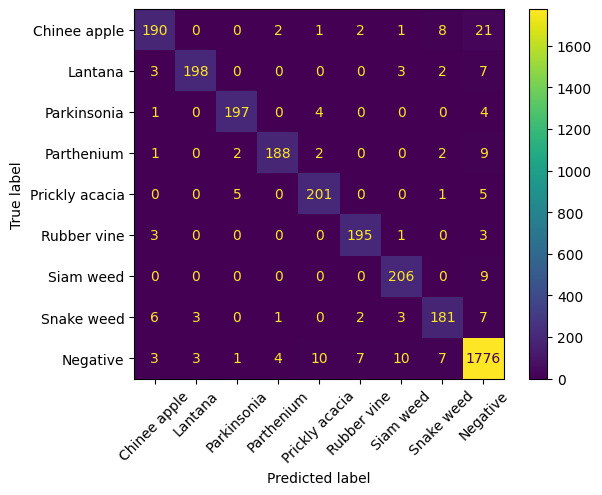

In [29]:
## Computing Positive Threshold Using Validation Dataset
a, b = eval_model(model,validation_generator)

model.evaluate
220/220 [==============================] - 3s 15ms/step - loss: 0.1523 - accuracy: 0.9507
model.predict


100%|██████████| 220/220 [00:32<00:00,  6.78it/s]


Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.94500   0.83628   0.88732       226
       Lantana    0.96569   0.92488   0.94484       213
   Parkinsonia    0.96279   1.00000   0.98104       207
    Parthenium    0.95000   0.92683   0.93827       205
Prickly acacia    0.92593   0.93897   0.93240       213
   Rubber vine    0.91626   0.92079   0.91852       202
     Siam weed    0.91739   0.98140   0.94831       215
    Snake weed    0.89855   0.91176   0.90511       204
      Negative    0.96507   0.97036   0.96771      1822

      accuracy                        0.95067      3507
     macro avg    0.93852   0.93459   0.93595      3507
  weighted avg    0.95081   0.95067   0.95040      3507


                False Positive Rate  Accuracy
Chinee apple               0.003353  0.836283
Lantana                    0.002125  0.924883
Parkinsonia                0.002424  1.000000
Parthenium                 0.003028  0.926829
Prickly acacia    

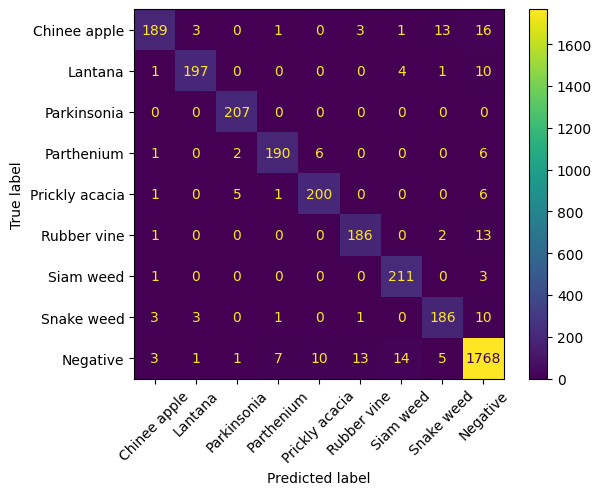

In [30]:
a, b = eval_model(model, test_generator)

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.90868   0.88053   0.89438       226
       Lantana    0.92727   0.95775   0.94226       213
   Parkinsonia    0.96279   1.00000   0.98104       207
    Parthenium    0.95000   0.92683   0.93827       205
Prickly acacia    0.88596   0.94836   0.91610       213
   Rubber vine    0.91626   0.92079   0.91852       202
     Siam weed    0.91342   0.98140   0.94619       215
    Snake weed    0.89855   0.91176   0.90511       204
      Negative    0.97702   0.95664   0.96672      1822

      accuracy                        0.94896      3507
     macro avg    0.92666   0.94267   0.93429      3507
  weighted avg    0.94968   0.94896   0.94906      3507


                False Positive Rate  Accuracy
Chinee apple               0.006096  0.880531
Lantana                    0.004857  0.957746
Parkinsonia                0.002424  1.000000
Parthenium                 0.003028  0.926829
Prickly acacia    

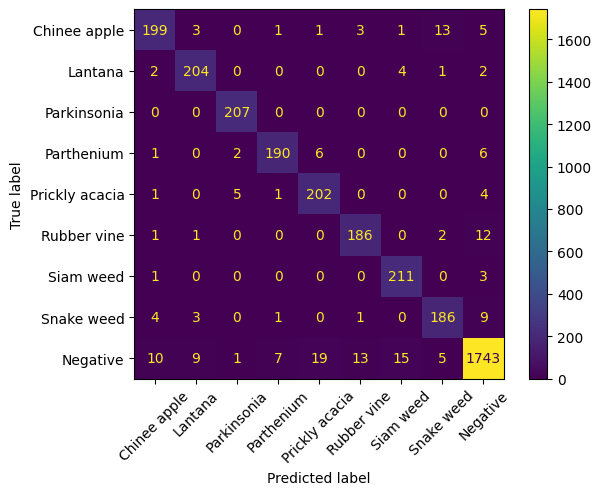

In [31]:
printStats(a,b,0.11)

## Clear Files

In [32]:
shutil.rmtree(base_dir)